# Assignment 2 - Regression + Outliers

*   Author: eeshanis
*   Date: 1/28/2026


### Data loading and Inspection

In [20]:
# all the imports for the entire notebook
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


In [21]:
# loading the dataset into a pandas dataframe
df = pd.read_csv("/content/usina_with_outliers.csv")

In [22]:
# getting basic information like shape and number of columns in the dataset
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

#displaying the dataframe
display(df.head())

#getting statistics on the csv like count, mean, std etc...
print("\nSummary statistics:")
display(df.describe(include="all"))

#identifying the missing values in the columns
print("\nMissing values per column:")
display(df.isna().sum())

Shape: (9568, 5)

Columns:
['AT', 'V', 'AP', 'RH', 'PE']


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90



Summary statistics:


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.618518,54.250021,1013.288871,73.308978,454.407820
std,8.256412,13.993655,6.636609,16.094499,18.760047
min,-39.174839,-38.397358,959.607298,-53.091613,327.528030
25%,13.480000,41.670000,1009.077500,63.227500,439.730000
50%,20.320000,52.080000,1012.950000,74.955000,451.620000
75%,25.732500,66.540000,1017.320000,84.882500,468.530000
max,77.344839,155.117358,1064.772702,187.691613,590.091970



Missing values per column:


,0
AT,0
V,0
AP,0
RH,0
PE,0


Summary of data inspection:
- there are no missing values in any column
- Column descriptions:
    - AT: ambient temperature (independent variable / IV)
    - V: Exhaust Vaccuum (independent variable / IV)
    - AP: Ambient Pressure (independent variable / IV)
    - RH: Relative Humidity (independent variable / IV)
    - PE: Power Output (target variable / DV)
- The summary statistics suggest that outliers could be present, since some columns have minimum and maximum values that are much smaller or larger than the interquartile range (25th–75th percentiles).

### **Utility Functions:**

For ease of use and clarity of code, I've included all the repetitive functions here:

1.   `split_data`: creates a 70/30 train-test-split with random state 42
2.   `compute_metrics`: computes the MSE, MAE, and R^2 metrics given the actual labels and the predicted labels.
3.   `prepare_xy`: This function drops the missing rows and splits the X from the y (target column)
4. `_get_linear_parts`: Extracting intercepts, coefficients, and feature names from either a linear or polynomial regression models.
5.  `print_fitted_equation`: prints the equation of the model that was fit
6.  `plot_actual_vs_predicted_test`: Presents a scatter plot on predicted versus actual values on the test set.
7.  `run_models_and_evaluate`: run, fit, and evaluate linear and/or polynomial regression models from the train and test sets.

These functions were sourced from the `Regression_Case_Study_Student_Performance.ipynb` from the in-class demo, and adapted to fit the goals of this assignment.


In [23]:
# This function splits the data into train test split sets with 70/30 split.
# It also sets the random state to 42 for reproducibility.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def split_data(X, y, test_size=0.30, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [24]:
# Returns the MSE, MAE, R^2
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def compute_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

In [25]:
# This function drops the missing rows and splits the X from the y
# inputs are df_in, the raw data frame with both x and y, and target_col, the
#        y column to separate.
# outputs are the new, cleaned data frame, target column.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def prepare_xy(df_in, target_col):
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

In [26]:
# Extract (intercept, coefficients, feature_names) from either:
# LinearRegression
# Pipeline(PolynomialFeatures -> LinearRegression)
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def _get_linear_parts(model, input_feature_names):
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

#Print a readable fitted equation.
#For polynomial models, the number of terms can become very large,
#so we print only the TOP-K terms by absolute coefficient magnitude.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def print_fitted_equation(model, input_feature_names, target_name, top_k_terms=15):
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)
    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

#Scatter plot of Actual vs Predicted values on the TEST set.
# We plot both series against a sample index, using:
# - Actual: blue circles
# - Predicted: red x's
# If test set is large, we randomly sample up to max_points points for readability.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

#Train/evaluate linear (deg=1) + polynomial regression models.
# Returns a DataFrame of metrics.
# Also prints fitted equations and scatter plots (test set) for each model.
# Source / Modified from: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def run_models_and_evaluate(scenario_name, X, y, X_train, X_test, y_train, y_test,
                            degrees, target_col, show_equation, show_plots,
                            top_k_terms):
    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train) #actual: y_train, predicted: yhat_train
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)

### Question 1: Outlier Detection and Removal with Cook's Distance

**Question 1.1 - Model Choice and Justification**

**Model:** Linear Regression

**Library:** statsmodels OLS

**Why did I choose this model?**

I chose linear regression because Cook’s Distance is defined for ordinary least squares models and directly measures how much each data point influences the fitted coefficients. Using linear regression keeps the connection between residuals, leverage, and outlier influence clear and interpretable without bringing in added suppression.

Ridge and Lasso are helpful for regularization, but because they shrink coefficients by design, they can hide the influence of individual points. Since this question is focused on detecting influential outliers rather than improving prediction, linear regression is a better fit.

**Why did I choose this library?**

I chose Statsmodels over scikit-learn because Cook’s Distance is a statistical influence indicator that comes from linear regression residuals and leverage values, and Statsmodels makes these influence measures easy to access. Scikit-learn is mainly built for prediction, and it doesn’t natively support influence diagnostics like Cook’s Distance, so using it here would require more custom implementation and be less transparent. This makes it not ideal for outlier analysis.

Source used to understand the difference between these two libraries: https://www.statology.org/understanding-the-difference-between-statsmodels-and-scikit-learn-when-to-use-each/

**1.2 Identify Outliers, remove them, and export clean CSV**

In [27]:
# identify outliers, remove them, and export a clean csv.
import statsmodels.api as sm

In [28]:
#The source I used to understand how to use statsmodels for linear regression: https://www.statology.org/cooks-distance-python/
#fitting the linear regression model using these features and targets
FEATURES = ["AT", "V", "AP", "RH"]
TARGET_COL = "PE"

X_og = df[FEATURES].copy()
y = df[TARGET_COL].copy()

X = sm.add_constant(X_og)
model = sm.OLS(y, X).fit()

In [29]:
# Compute Cook’s Distance for each data point.
influence = model.get_influence()
cooks_d, p_values = influence.cooks_distance

In [30]:
# identifying outliers using standard 4 / n
n = len(df)
threshold = 4 / n

# find outliers with boolean check
outlier_mask = cooks_d > threshold
outlier_indices = np.where(outlier_mask)[0]

print(f"Total data points in dataset: {n}")
print(f"Cook's Distance threshold (4/n): {threshold:.6f}")
print(f"Number of outliers found: {len(outlier_indices)}")


Total data points in dataset: 9568
Cook's Distance threshold (4/n): 0.000418
Number of outliers found: 120


In [31]:
#Removing outliers and creating the new dataframe
df_clean = df.loc[~outlier_mask].copy()

print("Validity check with size diff, should be 120: ", (df.shape[0] - df_clean.shape[0]))

Validity check with size diff, should be 120:  120


In [32]:
#exporting new clean dataframe to csv file.
df_clean.to_csv("usina.csv", index=False)

### Question 2: Train/Test Evaluation Before vs After Outliers Removed

In [33]:
# set up for question 2
lambdas = [0.01, 0.1, 1, 10, 100]
df_with_outliers = df.copy()
df_no_outliers = pd.read_csv("/content/usina.csv")

In [34]:
# cleaning the data for both data sets and separating the features from the target
X_w, y_w = prepare_xy(df_with_outliers, TARGET_COL)
X_c, y_c = prepare_xy(df_no_outliers, TARGET_COL)


In [35]:
# 70 /30 train test splitting
# for reproducibility, the random state is set to 42
Xw_train, Xw_test, yw_train, yw_test = split_data(X_w, y_w)
Xc_train, Xc_test, yc_train, yc_test = split_data(X_c, y_c)

In [36]:
#helper method for running linear, ridge, and lasso models
from sklearn.linear_model import Ridge, Lasso

def run_q2_models_and_evaluate(scenario_name,
                              X_train, X_test, y_train, y_test,
                              lambdas,
                              target_col,
                              show_equation=False,
                              show_plots=False,
                              top_k_terms=15):
    rows = []

    #linear regression
    model = LinearRegression()
    model_name = "Linear Regression"

    model.fit(X_train, y_train)

    yhat_train = model.predict(X_train)
    yhat_test  = model.predict(X_test)

    train_m = compute_metrics(y_train, yhat_train)
    test_m  = compute_metrics(y_test, yhat_test)

    rows.append({
        "Scenario": scenario_name,
        "Model": model_name,
        "Train MSE": train_m["MSE"],
        "Train MAE": train_m["MAE"],
        "Train R^2": train_m["R^2"],
        "Test MSE": test_m["MSE"],
        "Test MAE": test_m["MAE"],
        "Test R^2": test_m["R^2"],
        "Train size": len(X_train),
        "Test size": len(X_test),
    })

    #ridge and lasso models for each lambda
    for lam in lambdas:
        #Ridge
        ridge = Ridge(alpha=lam)
        ridge_name = f"Ridge (λ={lam})"

        ridge.fit(X_train, y_train)

        ridge_yhat_train = ridge.predict(X_train)
        ridge_yhat_test  = ridge.predict(X_test)

        ridge_train_m = compute_metrics(y_train, ridge_yhat_train)
        ridge_test_m  = compute_metrics(y_test, ridge_yhat_test)

        rows.append({
            "Scenario": scenario_name,
            "Model": ridge_name,
            "Train MSE": ridge_train_m["MSE"],
            "Train MAE": ridge_train_m["MAE"],
            "Train R^2": ridge_train_m["R^2"],
            "Test MSE": ridge_test_m["MSE"],
            "Test MAE": ridge_test_m["MAE"],
            "Test R^2": ridge_test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

        # Lasso
        lasso = Lasso(alpha=lam, max_iter=10000, random_state=42)
        lasso_name = f"Lasso (λ={lam})"

        lasso.fit(X_train, y_train)

        lasso_yhat_train = lasso.predict(X_train)
        lasso_yhat_test  = lasso.predict(X_test)

        lasso_train_m = compute_metrics(y_train, lasso_yhat_train)
        lasso_test_m  = compute_metrics(y_test, lasso_yhat_test)

        rows.append({
            "Scenario": scenario_name,
            "Model": lasso_name,
            "Train MSE": lasso_train_m["MSE"],
            "Train MAE": lasso_train_m["MAE"],
            "Train R^2": lasso_train_m["R^2"],
            "Test MSE": lasso_test_m["MSE"],
            "Test MAE": lasso_test_m["MAE"],
            "Test R^2": lasso_test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    df_out = pd.DataFrame(rows)
    desired_cols = ["Scenario", "Model", "Train MSE", "Train MAE", "Train R^2",
                    "Test MSE", "Test MAE", "Test R^2","Train size", "Test size"]
    return df_out[desired_cols]


In [37]:
#with outliers models and evaluations
q2_with = run_q2_models_and_evaluate(
    scenario_name="With Outliers",
    X_train=Xw_train, X_test=Xw_test,
    y_train=yw_train, y_test=yw_test,
    lambdas=lambdas,
    target_col=TARGET_COL,
    show_equation=False,
    show_plots=False
)

#without outliers models and evaluations
q2_clean = run_q2_models_and_evaluate(
    scenario_name="Without Outliers",
    X_train=Xc_train, X_test=Xc_test,
    y_train=yc_train, y_test=yc_test,
    lambdas=lambdas,
    target_col=TARGET_COL,
    show_equation=False,
    show_plots=False
)

print("WITH OUTLIERS --- usina_with_outliers.csv dataset")
display(q2_with)

print(" ")
print("WITHOUT OUTLIERS ---- usina.csv")
display(q2_clean)

WITH OUTLIERS --- usina_with_outliers.csv dataset


,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,With Outliers,Linear Regression,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574,6697,2871
1,With Outliers,Ridge (λ=0.01),123.384207,5.198679,0.650171,125.113389,5.052458,0.642574,6697,2871
2,With Outliers,Lasso (λ=0.01),123.384210,5.198858,0.650171,125.115332,5.052626,0.642568,6697,2871
3,With Outliers,Ridge (λ=0.1),123.384207,5.198680,0.650171,125.113392,5.052459,0.642574,6697,2871
4,With Outliers,Lasso (λ=0.1),123.384607,5.201739,0.650169,125.134495,5.055348,0.642514,6697,2871
5,With Outliers,Ridge (λ=1),123.384207,5.198685,0.650171,125.113421,5.052463,0.642574,6697,2871
6,With Outliers,Lasso (λ=1),123.421151,5.229507,0.650066,125.338356,5.083092,0.641931,6697,2871
7,With Outliers,Ridge (λ=10),123.384207,5.198737,0.650171,125.113705,5.052513,0.642573,6697,2871
8,With Outliers,Lasso (λ=10),126.141514,5.540418,0.642353,128.902136,5.408803,0.631750,6697,2871
9,With Outliers,Ridge (λ=100),123.384213,5.199261,0.650171,125.116548,5.053003,0.642565,6697,2871


 
WITHOUT OUTLIERS ---- usina.csv


,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Without Outliers,Linear Regression,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302,6613,2835
1,Without Outliers,Ridge (λ=0.01),19.864671,3.596396,0.931369,20.396772,3.624773,0.930302,6613,2835
2,Without Outliers,Lasso (λ=0.01),19.864675,3.596368,0.931369,20.396738,3.624754,0.930302,6613,2835
3,Without Outliers,Ridge (λ=0.1),19.864671,3.596397,0.931369,20.396770,3.624773,0.930302,6613,2835
4,Without Outliers,Lasso (λ=0.1),19.865263,3.596855,0.931367,20.392600,3.624890,0.930316,6613,2835
5,Without Outliers,Ridge (λ=1),19.864671,3.596400,0.931369,20.396750,3.624774,0.930302,6613,2835
6,Without Outliers,Lasso (λ=1),19.929852,3.605523,0.931144,20.414755,3.631153,0.930241,6613,2835
7,Without Outliers,Ridge (λ=10),19.864672,3.596430,0.931369,20.396549,3.624783,0.930303,6613,2835
8,Without Outliers,Lasso (λ=10),25.685683,4.086632,0.911258,26.157253,4.120464,0.910618,6613,2835
9,Without Outliers,Ridge (λ=100),19.864758,3.596742,0.931369,20.394626,3.624880,0.930310,6613,2835


**Question 2 Discussion:**

1.**Do outliers change train error? Test error?**

Outliers increase both training and testing errors. With outliers, the linear regression model has a test MSE of ~125, a test MAE of 5.05, and a test R^2 value of 0.64. Without the outliers, this same model achieved a test MSE of 20.39, a test MAE of 3.62, and a test R^2 value of 0.93.  This same model had a train MSE of ~123 and then without outliers achieved a train MSE of 19.86. This shows dramatic improvement in the model's fit to the underlying relationship of the data when the outliers are removed for both train and test errors.

This pattern was observed in Ridge and Lasso models as well. With outliers, both Ridge and Lasso models with lambda=0.1 had a test MSE of ~125 which became a test MSE of 20 when outliers were removed.


2. **Which dataset (with outliers or without outliers) shows better generalization?**

The outlier removed dataset shows better generalization because there is much lower test MSE and MAE, as well as higher test R^2 values after the outliers were removed. With outliers, the linear regression model has a test MSE of ~125, a test MAE of 5.05, and a test R^2 value of 0.64. Without the outliers, this same model achieved a test MSE of 20.39, a test MAE of 3.62, and a test R^2 value of 0.93.
With outliers, both Ridge and Lasso models with lambda=0.1 had a test MSE of ~125 which became a test MSE of 20 when outliers were removed.

Additionally, the reduced gap between training and test performance in the clean dataset suggests a more stable model that better captures the true underlying relationship between the features and target variables. For example, the without outliers Linear regression model shows a train MSE of ~19.9 and a test MSE of 20.4.

3. **Do ridge / lasso appear to help relative to standard linear regression?**

In this case, Ridge or Lasso regression does not meaningfully improve performance over standard linear regression, as the test metrics are nearly identical across all tested lambda values. In the without outliers model results, we see a test MSE of ~20 for both Ridge, Lasso, and Linear regression. The only exception is when Lasso has a really large lambda (10) in which case the performance dips (test MSE = ~132) due to excessive coefficient shrinkage, keeping it unhelpful relative to Linear Regression. This suggests that multicollinearity is not a major issue in this dataset.

 Since the primary issue affecting model performance was the outliers rather than overfitting or multicollinearity, regularization does not provide a clear benefit here.

### Question 3: Reliability of Coefficients without Outliers

**Question 3.1**

**Model:** Linear Regression

**Library:** statsmodels OLS

**Why did I choose this model?**

I chose linear regression because linear regression keeps the connection between residuals, leverage, and outlier influence clear and interpretable without bringing in added coefficient suppression.

Ridge and Lasso are helpful for regularization, but because they shrink coefficients by design, which alters their magnitude and makes statistical inference less interpretable. Since this question focuses on coefficient reliability rather than prediction performance, linear regression is the most appropriate choice.

**Why did I choose this library?**

I chose Statsmodels over scikit-learn because Statsmodels is designed for statistical inference and directly provides coefficient estimates, standard errors, t-statistics, and p-values. Scikit-learn is primarily built for prediction and does not natively support inference metrics, making it less suitable (and more error prone for me at least) for evaluating coefficient reliability.

Source used to understand the difference between these two libraries: https://www.statology.org/understanding-the-difference-between-statsmodels-and-scikit-learn-when-to-use-each/

Would I scale IV / DV for this coefficient reliability task?

No, I wouldn't scale any of the variables because scaling doesn't impact the t-statistics. T-statistics are given as **t_j = B_hat_j / Standard Error of B_hat_j**

Both the coefficient and its standard error scale by the same factor, which cancels out. Since scaling is mainly useful for comparing coefficient magnitudes between features with different units ( for example, feature importance), it is unnecessary for assessing reliability.

### 3.2 Implementation + Results

In [57]:
# using df_no_outliers to fit linear regression model
# with statsmodels
X_og_clean = df_no_outliers[FEATURES].copy()
y = df_no_outliers[TARGET_COL].copy()

X = sm.add_constant(X_og_clean)
model = sm.OLS(y, X).fit()

print("Without Outliers -- T-Values of All Features: ")
display(model.tvalues)

Without Outliers -- T-Values of All Features: 


,0
const,45.264539
AT,-129.113036
V,-33.056481
AP,7.894540
RH,-36.897303


**Most reliable coefficient:** AT

**Least reliable coefficient:** AP

Reasoning:
I used the absolute t-statistics from the OLS fit as the reliability measure. When the absolute t-statistic is high, it indicates high coefficient reliability and when the absolute t-statistic is low, it indicates low coefficient reliability.

- **largest absolute t value**: AT at 129.11 or (-129.11 without absolute value)

- **smallest absolute t value:** AP at 7.8945

- **Ranking absolute t values / most reliable to least reliable coefficients:** AT, RH, V, AP

### Question 4: Most Important vs Least Important Features without Outliers

**4.1 Method of Choice + Scaling decision**

**Model:** Linear Regression

**Library:** scikit learn

**Why did I choose this model?**

I chose standard linear regression because the goal of this question is to rank features by importance based on their relative effect on the model, not to perform feature selection or control overfitting.

Ridge and Lasso add regularization penalties that shrink coefficients. While Lasso is useful for feature selection because it can push some coefficients to zero, this dataset only has four features and does not show strong evidence of multicollinearity or overfitting (as seen in question 2). Using regularization regression models could introduce additional bias and even distort the true relative magnitudes of the coefficients.

Since the goal here is to compare feature importance rather than eliminate variables, standard linear regression provides the clearest and most direct interpretation of the features' effects.

Resource I for this: https://medium.com/@SelinKarabulut/when-to-use-lasso-ridge-or-elastic-net-regression-a-complete-guide-2e16a67fc255

**Why did I choose this library?**

I chose scikit-learn because this part requires scaling the features and comparing coefficient magnitudes, and scikit-learn integrates directly with StandardScaler making these tasks easier. Since statistical inference (like t-values) is not required here, statsmodels was unnecessary.

**Would I scale IV / DV for this feature importance task?**

Yes, I would scale the independent variables, but I would not scale the dependent variable. Scaling the IVs is important when comparing coefficient magnitudes to determine feature importance. Without scaling, features measured in larger units could appear more important just because of their scale rather than their true effect on the target variable. By standardizing the IVs, the coefficients become directly comparable across features. I would not scale the DV because scaling the target variable does not change the relative ranking of feature importance.

4.2 Implementation and Results

In [58]:
#linear regression, scikit learn, scaled
from sklearn.preprocessing import StandardScaler

#scaled x values (IVs)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_og_clean) #x_og is from the no-outliers data frame from part 3.2

# fitting linear regression model on the scaled features
lr = LinearRegression()
lr.fit(X_scaled, y)


coef_df = pd.DataFrame({"Feature": FEATURES,
                        "Coefficient": lr.coef_,
                        "Absolute Coefficient": np.abs(lr.coef_)})

print("Scaled feature coefficients: ")
display(coef_df)

Scaled feature coefficients: 


,Feature,Coefficient,Absolute Coefficient
0,AT,-14.556614,14.556614
1,V,-3.030737,3.030737
2,AP,0.442513,0.442513
3,RH,-2.197120,2.197120


Most Important Feature: AT

Least Important feature: AP

Reasoning:
Since the features were scaled before fitting the model, the coefficient magnitudes are directly comparable. Whichever coefficient has the largest absolute coefficient value, has the largest impact on the target variable making it the most important feature (and vice versa for the least important). Therefore, AT, which has an absolute coefficient of 14.55, is the most important feature, and AP, which has the least absolute coefficient value of 0.445, is the least important feature.

### Question 5: Regularization Paths

In [54]:
# 100 values of lambda between 10^-2 = 0.01 to 10^3 = 1000
lambdas = np.logspace(-3, 3, 100)

#X_scaled is the outlier removed scaled features dataset using StandardScaler
y = df_no_outliers[TARGET_COL].copy()

#this function sweeps the given model ridge or lasso for an array of lambdas
#then it returns a dataframe containing each model and it's coefficients
def sweep_coef_paths(model_type: str, y=y, lambda_grid=lambdas,  X_scaled=X_scaled):
    rows = []

    for lam in lambda_grid:
        if model_type == "Ridge":
            model = Ridge(alpha=lam, random_state=42)
        elif model_type == "Lasso":
            model = Lasso(alpha=lam, max_iter=50000, random_state=42)

        model.fit(X_scaled, y)

        row = {"lambda": float(lam)}
        for j, feat in enumerate(FEATURES):
            row[feat] = model.coef_[j]
        rows.append(row)

    return pd.DataFrame(rows)



In [55]:
#sweeping the models
ridge_paths = sweep_coef_paths("Ridge")
lasso_paths = sweep_coef_paths("Lasso")

display(ridge_paths)
print(" ")
display(lasso_paths)

,lambda,AT,V,AP,RH
0,0.001000,-14.556605,-3.030742,0.442515,-2.197117
1,0.001150,-14.556604,-3.030743,0.442515,-2.197117
2,0.001322,-14.556603,-3.030744,0.442515,-2.197116
3,0.001520,-14.556601,-3.030745,0.442516,-2.197116
4,0.001748,-14.556599,-3.030746,0.442516,-2.197115
...,...,...,...,...,...
95,572.236766,-11.485726,-4.703470,1.153177,-1.080804
96,657.933225,-11.200334,-4.831523,1.221636,-0.972827
97,756.463328,-10.903924,-4.957224,1.293085,-0.859792
98,869.749003,-10.598357,-5.078149,1.367024,-0.742312


,lambda,AT,V,AP,RH
0,0.001000,-14.559087,-3.028253,0.441259,-2.196555
1,0.001150,-14.558696,-3.028340,0.441242,-2.196222
2,0.001322,-14.558247,-3.028441,0.441223,-2.195840
3,0.001520,-14.557730,-3.028556,0.441202,-2.195401
4,0.001748,-14.557136,-3.028688,0.441177,-2.194896
...,...,...,...,...,...
95,572.236766,-0.000000,-0.000000,0.000000,0.000000
96,657.933225,-0.000000,-0.000000,0.000000,0.000000
97,756.463328,-0.000000,-0.000000,0.000000,0.000000
98,869.749003,-0.000000,-0.000000,0.000000,0.000000


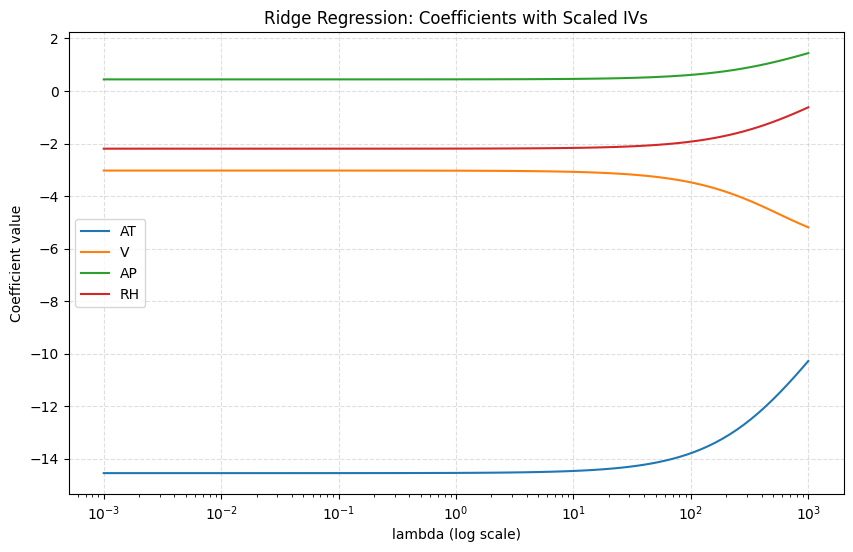

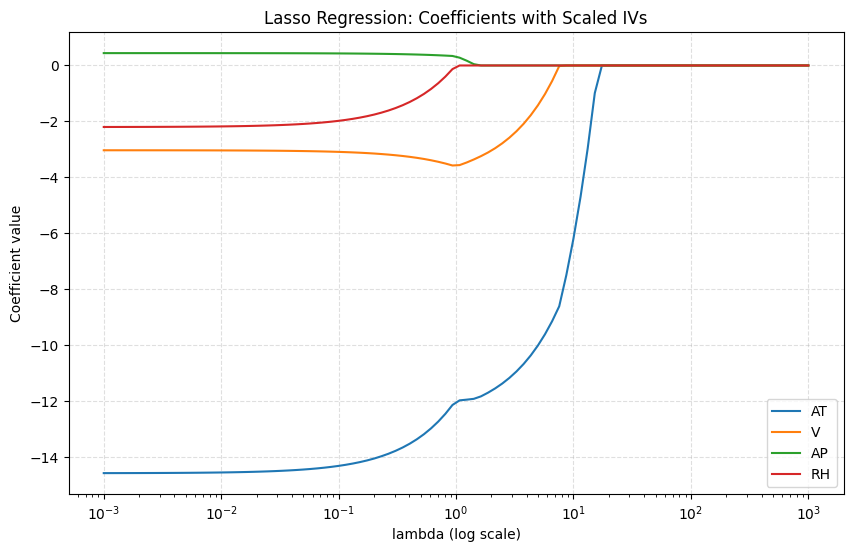

In [60]:
# Ridge coefficient paths
plt.figure(figsize=(10,6))
for feat in FEATURES:
    plt.plot(ridge_paths["lambda"], ridge_paths[feat], label=feat)

plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression: Coefficients with Scaled IVs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()

# Lasso coefficient paths
plt.figure(figsize=(10,6))
for feat in FEATURES:
    plt.plot(lasso_paths["lambda"], lasso_paths[feat], label=feat)

plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression: Coefficients with Scaled IVs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()


Question 5 Discussion

- What happens to the coefficients as lambda increases in ridge vs. Lasso?

Ridge:
As lambda increases, the coefficients shrink smoothly towards zero. The shrinking is gradual but continuous, and these coefficients never reach exactly zero. All features remain in the model, even when lambda gets really large. This is because ridge uses a l2 penalty that reduces large values while still keeping all variables. There are also some coefficients that are driven away from 0 (like V and AP) as lambda gets really large. This is because the model is redistributing the weights of the correlated features as lambda increases making certain features increase as others decrease.

Lasso: The coefficients shrink more aggressively and as lambda increases also get driven to 0. At super large values of lambda (~10^1), we can see all the coefficients go to 0, meaning no features are left in the model. Lasso promotes sparsity with the l1 penalty which leads to this complete elimination in features.

- Which regression is better under multicollinearity in IVs and why?

Ridge is better under multicollinearity in IVS because when the IVs are highly correlated, OLS estimates can have high variance and be unstable. Ridge smoothly suppresses these correlated coefficients and "rebalances" their weights while keeping both features. Lasso on the other hand selects one correlated feature and shrinks the others to zero, which can make the model more unstable when there is strong multicollinearity.

- Which regression is better for feature selection and why?

Lasso is better for feature selection because it drives some coefficients to 0. This removes these features from the model, effectively doing feature selection since it removes the less important features and produces a sparser and more interpretable model. Ridge regression cannot drive any coefficient to 0 therefore cannot eliminate the unimportant features, just redistribute their weights.
